In [10]:
import keras 
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from utils import get_data, serialize_data, next_batch, breed_overview
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print tf.__version__

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

1.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8912234755309966295
]


In [2]:
root_dir = "/home/anne/src/dog_identification/"  
train_zip = root_dir + "data/train.zip"
valid_zip = root_dir + "data/valid.zip"
training_filename = root_dir + "data/train.p"
validation_filename = root_dir + "data/valid.p"
labels_filename = root_dir + "data/labels.csv.zip"

num_validation = 0.3
batch_size = 50
n_batches = 50

n_breeds = 20

nwidth = 80
nheight = 80

### Load datasets

In [3]:
# Load the whole dataset into memory
serialize_data(train_zip, labels_filename, training_filename, img_size=nwidth)
x, y, breed_dict = get_data(training_filename, labels_filename, top_breeds=n_breeds)

Creating serialized file format for /home/anne/src/dog_identification/data/train.zip
pickle file already exists, continueing
Loading pickle file /home/anne/src/dog_identification/data/train.p


In [4]:
y_hot = keras.utils.to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y_hot, test_size=num_validation, random_state=6)

# Eval train test sets
unique_train, freq_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
unique_val, freq_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)

# Make sure every breed is included in both sets
assert (unique_train.shape[0]==unique_val.shape[0]), "Missing breeds in train/val sets"

print("Label frequency training set: max=%d, min=%d" % (np.amax(freq_train), np.amin(freq_train)))
print("Label frequency validation set: max=%d, min=%d" % (np.amax(freq_val), np.amin(freq_val)))

# Create data flow objects
nb_train_samples = x_train.shape[0]
nb_val_samples = x_val.shape[0]

train_gen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.1,
        channel_shift_range=0.1,
        horizontal_flip=True)
train_gen.fit(x_train)
train_flow = train_gen.flow(x_train, y_train, batch_size=batch_size)

val_gen = ImageDataGenerator()
val_gen.fit(x_val)
val_flow =val_gen.flow(x_val, y_val, batch_size=batch_size)

Label frequency training set: max=86, min=68
Label frequency validation set: max=40, min=26


### Make sure images and labels are correct

In [ ]:
INPUT_SIZE = 299
POOLING = 'avg'
x_proc = np.zeros((x.shape[0], INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img in tqdm(enumerate(x)):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x_tmp = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_proc[i] = x_tmp
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

### Create model

In [5]:
xception_bottleneck = xception.Xception(weights = "imagenet", include_top=False, pooling='avg', input_shape = (nwidth, nheight, 3))

train_x_bf = xception_bottleneck.predict(x_train, batch_size=batch_size, verbose=1)
valid_x_bf = xception_bottleneck.predict(x_val, batch_size=batch_size, verbose=1)

print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

656/656 [==============================] - 19s 29ms/step


### Modify pre-trained model

In [12]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=6)
logreg.fit(train_x_bf, (y_train * range(n_breeds)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(y_val, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((y_val * range(n_breeds)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 2.48841686393
Validation Xception Accuracy 0.448170731707


### Train generator

In [15]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("data/vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [16]:
epochs = 100

# Train the model 
hist = model_final.fit_generator(
        train_flow,
        steps_per_epoch = nb_train_samples // batch_size,
        epochs = epochs,
        validation_data = val_flow,
        validation_steps = nb_val_samples // batch_size,
        callbacks = [checkpoint, early])

Epoch 1/100
30/30 [==============================] - 11s 369ms/step - loss: 2.8029 - acc: 0.1511 - val_loss: 2.7754 - val_acc: 0.1754
Epoch 2/100
30/30 [==============================] - 11s 360ms/step - loss: 2.8218 - acc: 0.1408 - val_loss: 2.7741 - val_acc: 0.1692
Epoch 3/100
30/30 [==============================] - 11s 363ms/step - loss: 2.7923 - acc: 0.1607 - val_loss: 2.7710 - val_acc: 0.1692
Epoch 4/100
30/30 [==============================] - 11s 361ms/step - loss: 2.8039 - acc: 0.1459 - val_loss: 2.7703 - val_acc: 0.1708
Epoch 5/100
30/30 [==============================] - 11s 357ms/step - loss: 2.8186 - acc: 0.1332 - val_loss: 2.7699 - val_acc: 0.1646
Epoch 6/100
30/30 [==============================] - 11s 360ms/step - loss: 2.8124 - acc: 0.1411 - val_loss: 2.7668 - val_acc: 0.1738
Epoch 7/100
30/30 [==============================] - 11s 364ms/step - loss: 2.8031 - acc: 0.1500 - val_loss: 2.7655 - val_acc: 0.1662
Epoch 8/100
30/30 [==============================] - 11s 360ms

### Evaluate training

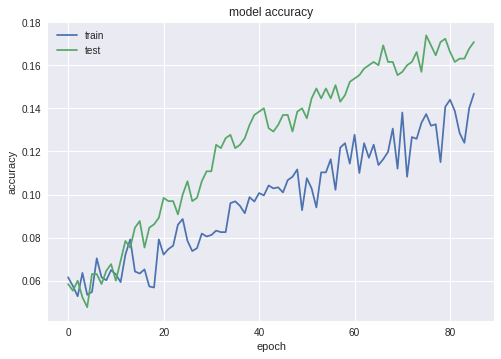

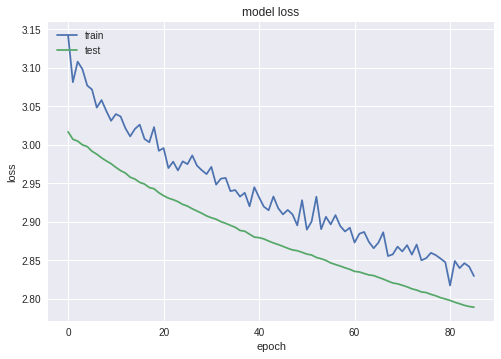

In [9]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()